# GAN训练
## 引入

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from models import GAN
from utils import load_safari

## 环境参数

In [2]:
# run params
SECTION = "gan"
RUN_ID = "0001"
DATA_NAME = "camel"
RUN_FOLDER = f"run/{SECTION}/"
RUN_FOLDER += "_".join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.makedirs(os.path.join(RUN_FOLDER, "viz"))
    os.makedirs(os.path.join(RUN_FOLDER, "images"))
    os.makedirs(os.path.join(RUN_FOLDER, "weights"))

MODE = "build" # "load"

## 加载数据

In [3]:
(x_train, y_train) = load_safari(DATA_NAME)
x_train.shape

(80000, 28, 28, 1)

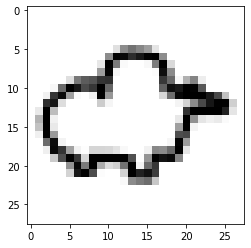

In [5]:
plt.imshow(x_train[200, :, :, 0], cmap="Greys")

## 神经网络结构

In [6]:
gan = GAN(
    input_dim=(28, 28, 1),
    discriminator_conv_filters=[64, 64, 128, 128],
    discriminator_conv_kernel_size=[5, 5, 5, 5],
    discriminator_conv_strides=[2, 2, 2, 1],
    discriminator_batch_norm_momentum=None,
    discriminator_activation="relu",
    discriminator_dropout_rate=0.4,
    discriminator_learning_rate=0.0008,
    generator_initial_dense_layer_size=(7, 7, 64),
    generator_upsample=[2, 2, 1, 1],
    generator_conv_filters=[128, 64, 64, 1],
    generator_conv_kernel_size=[5, 5, 5, 5],
    generator_conv_strides=[1, 1, 1, 1],
    generator_batch_norm_momentum=0.9,
    generator_activation="relu",
    generator_dropout_rate=None,
    generator_learning_rate=0.0004,
    optimizer="rmsprop",
    z_dim=100
)

if MODE == "build":
    gan.save(RUN_FOLDER)
else:
    gan.load_weights(os.path.join(RUN_FOLDER, "weights/weights.h5"))

In [7]:
gan.discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 28, 28, 1)]       0         
_________________________________________________________________
discriminator_conv_0 (Conv2D (None, 14, 14, 64)        1664      
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
discriminator_conv_1 (Conv2D (None, 7, 7, 64)          102464    
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0     

In [8]:
gan.generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
activation_4 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
generator_conv_0 (Conv2D)    (None, 14, 14, 128)       2049

## 训练GAN

In [ ]:
BATCH_SIZE = 64
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 5

gan.train(
    x_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    run_folder=RUN_FOLDER,
    print_every_n_batches=PRINT_EVERY_N_BATCHES
)

## 训练损失可视化

In [ ]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color="black", linewidth=0.25)
plt.plot([x[1] for x in gan.d_losses], color="green", linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color="red", linewidth=0.25)
plt.plot([x[0] for x in gan.g_losses], color="orange", linewidth=0.25)

plt.xlabel("batch", fontsize=18)
plt.ylabel("loss", fontsize=16)
plt.xlim(0, 2000)
plt.ylim(0, 2)
plt.show()


In [ ]:
fig = plt.figure()
plt.plot([x[3] for x in gan.d_losses], color="black", linewidth=0.25)
plt.plot([x[4] for x in gan.d_losses], color="green", linewidth=0.25)
plt.plot([x[5] for x in gan.d_losses], color="red", linewidth=0.25)
plt.plot([x[1] for x in gan.g_losses], color="orange", linewidth=0.25)

plt.xlabel("batch", fontsize=18)
plt.ylabel("accuracy", fontsize=16)
plt.xlim(0, 2000)
plt.show()

## 生成图片及对比与生成图片相似的原始图片

In [ ]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [ ]:
r, c = 5, 5

idx = np.random.randint(0, x_train.shape[0], 32)
true_imgs = (x_train[idx] + 1) * 0.5

fig, axs = plt.subplots(r, c, figsize=(15, 15))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(true_imgs[cnt], cmap="Greys")
        axs[i, j].axis("off")
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/real.png"))
plt.close()

In [ ]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, gan.z_dim))
gen_imgs = gan.generator.predict(noise)
gen_imgs = 0.5 * (gen_imgs + 1)

fig, axs = plt.subplots(r, c, figsize=(15, 15))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(np.squeeze(gen_imgs[cnt, :, :, :]), cmap="Greys")
        axs[i, j].axis("off")
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/sample.png"))
plt.close()

fig, axs = plt.subplots(r, c, figsize=(15, 15))
cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate((x_train + 1) * 0.5):
            diff = compare_images(gen_imgs[cnt, :, :, :], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="Greys")
        axs[i, j].axis("off")
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/sample_closest.png"))
plt.close()